### Домашнее задание №4

### Бабушкина Татьяна М05-012б

In [60]:
from lenskit.datasets import MovieLens
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import basic, Recommender, funksvd, als, item_knn, user_knn
import pandas as pd
import numpy as np
import tqdm

In [18]:
#ml100k = MovieLens("data/ml-latest-small")

### Эксперименты с lenskit

In [104]:
ratings = pd.read_csv('ratings2.csv')#ml100k.ratings
ratings.head()

,user,item,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [29]:
ratings.shape

(100836, 6)

In [30]:
ratings.rating.unique()

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

In [31]:
algo_ii = item_knn.ItemItem(50)
algo_als = als.BiasedMF(50, progress=tqdm.tqdm)
algo_svd = funksvd.FunkSVD(50)
algo_impl = als.ImplicitMF(50, progress=tqdm.tqdm)
algo_uu = user_knn.UserUser(50)

In [32]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [35]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 10, xf.SampleFrac(0.2)):
#     print(len(test))
    test_data.append(test)
    all_recs.append(eval('ItemItem', algo_ii, train, test))
    all_recs.append(eval('BiasedALS', algo_als, train, test))
    all_recs.append(eval('UserUser', algo_uu, train, test))
    all_recs.append(eval('SVD', algo_svd, train, test))
    all_recs.append(eval('ImplicitALS', algo_impl, train, test))

In [36]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs.head()

,item,score,user,rank,Algorithm
0,389,5.497957,15,1,ItemItem
1,40,5.283937,15,2,ItemItem
2,3855,5.244698,15,3,ItemItem
3,38388,5.160094,15,4,ItemItem
4,26810,5.158132,15,5,ItemItem


In [37]:
all_recs.to_csv('1.csv')
all_recs.head(10)

,item,score,user,rank,Algorithm
0,389,5.497957,15,1,ItemItem
1,40,5.283937,15,2,ItemItem
2,3855,5.244698,15,3,ItemItem
3,38388,5.160094,15,4,ItemItem
4,26810,5.158132,15,5,ItemItem
5,670,5.067881,15,6,ItemItem
6,5915,4.985708,15,7,ItemItem
7,3302,4.979538,15,8,ItemItem
8,7486,4.911444,15,9,ItemItem
9,74727,4.865379,15,10,ItemItem


In [40]:
test_data = pd.concat(test_data, ignore_index=True)
test_data.head()

In [41]:
test_data.to_csv('2.csv')

In [42]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(all_recs, test_data)
results.head()

nrecs      ndcg
Algorithm user                 
BiasedALS 1     100.0  0.039513
          2     100.0  0.000000
          3     100.0  0.000000
          4     100.0  0.006566
          5     100.0  0.025256

In [43]:
results.groupby('Algorithm').ndcg.mean()

Algorithm
BiasedALS      0.072250
ImplicitALS    0.262191
ItemItem       0.001851
SVD            0.036382
UserUser       0.000536
Name: ndcg, dtype: float64

<AxesSubplot:xlabel='Algorithm'>

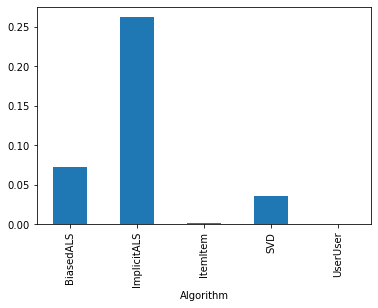

In [44]:
results.groupby('Algorithm').ndcg.mean().plot.bar()

In [45]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.recip_rank)
results = rla.compute(all_recs, test_data)
results.head()

nrecs  recip_rank
Algorithm user                   
BiasedALS 1     100.0    0.035714
          2     100.0    0.000000
          3     100.0    0.000000
          4     100.0    0.015385
          5     100.0    0.018868

In [46]:
results.groupby('Algorithm').recip_rank.mean()

Algorithm
BiasedALS      0.143679
ImplicitALS    0.318773
ItemItem       0.005844
SVD            0.057435
UserUser       0.003179
Name: recip_rank, dtype: float64

<AxesSubplot:xlabel='Algorithm'>

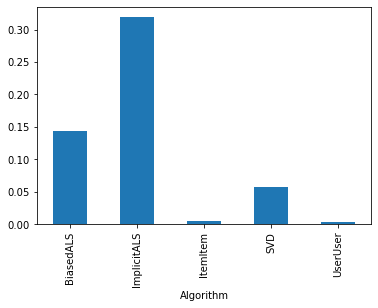

In [47]:
results.groupby('Algorithm').recip_rank.mean().plot.bar()

In [48]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.precision)
results = rla.compute(all_recs, test_data)
results.head()

nrecs  precision
Algorithm user                  
BiasedALS 1     100.0       0.03
          2     100.0       0.00
          3     100.0       0.00
          4     100.0       0.01
          5     100.0       0.01

In [49]:
results.groupby('Algorithm').precision.mean()

Algorithm
BiasedALS      0.025984
ImplicitALS    0.089246
ItemItem       0.001590
SVD            0.011541
UserUser       0.000427
Name: precision, dtype: float64

<AxesSubplot:xlabel='Algorithm'>

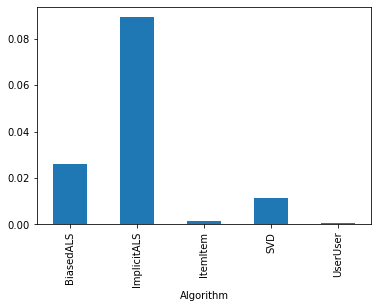

In [50]:
results.groupby('Algorithm').precision.mean().plot.bar()

In [51]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.recall)
results = rla.compute(all_recs, test_data)
results.head()

nrecs    recall
Algorithm user                 
BiasedALS 1     100.0  0.065217
          2     100.0  0.000000
          3     100.0  0.000000
          4     100.0  0.023256
          5     100.0  0.111111

In [52]:
results.groupby('Algorithm').recall.mean()

Algorithm
BiasedALS      0.109683
ImplicitALS    0.448179
ItemItem       0.003195
SVD            0.072584
UserUser       0.000611
Name: recall, dtype: float64

<AxesSubplot:xlabel='Algorithm'>

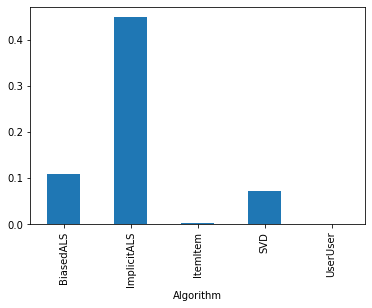

In [54]:
results.groupby('Algorithm').recall.mean().plot.bar()